Import libraries

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt
import collections
import re

from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load Dataset

In [13]:
# Load the IMDB dataset in supervised mode (each example returns a (review, label) pair)
def load_imdb_data():
    imdb, _ = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
    return imdb['train'], imdb['test']

train_data, test_data = load_imdb_data()

Split into Test, Validation and Train

In [14]:
# Split training data into training and validation sets.
def split_train_validation(train_data, validation_split=0.2):
    train_list = list(train_data.skip(int(validation_split * len(list(train_data)))).as_numpy_iterator())
    validation_list = list(train_data.take(int(validation_split * len(list(train_data)))).as_numpy_iterator())

    train_labels = [label for _, label in train_list]
    validation_labels = [label for _, label in validation_list]

    print(f"Training set size: {len(train_list)}")
    print(f"Validation set size: {len(validation_list)}")

    return train_list, validation_list, train_labels, validation_labels

train_list, validation_list, train_labels, validation_labels = split_train_validation(train_data)

test_list = list(test_data.as_numpy_iterator())
test_labels = [label for _, label in test_list]

print(f"Test set size: {len(test_list)}")

Training set size: 20000
Validation set size: 5000
Test set size: 25000


EDA

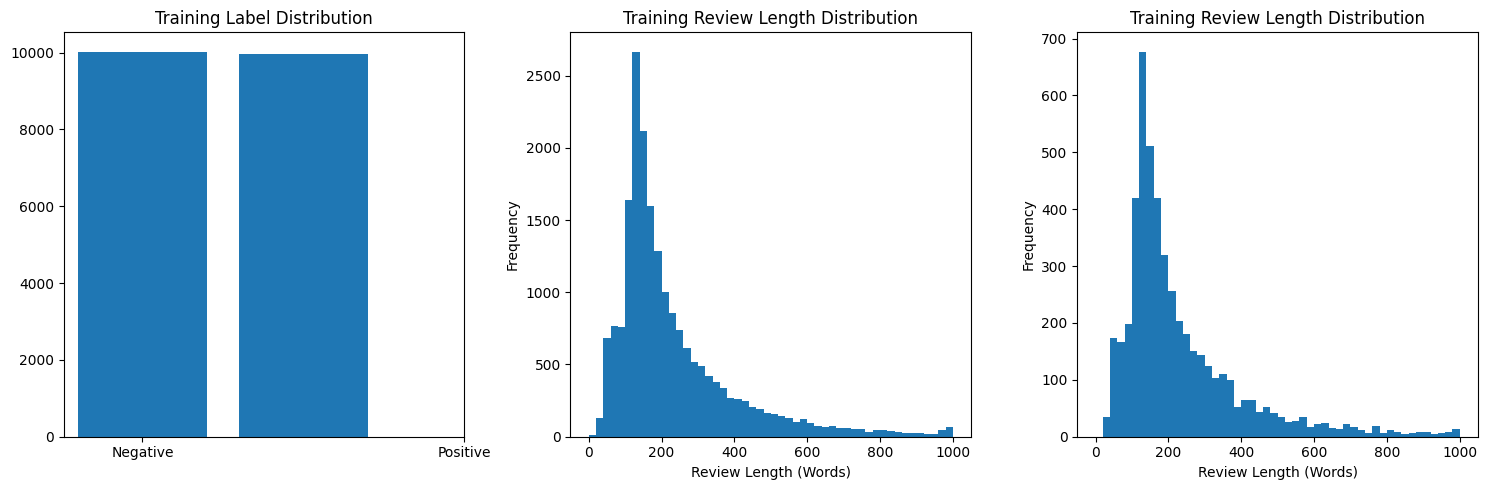

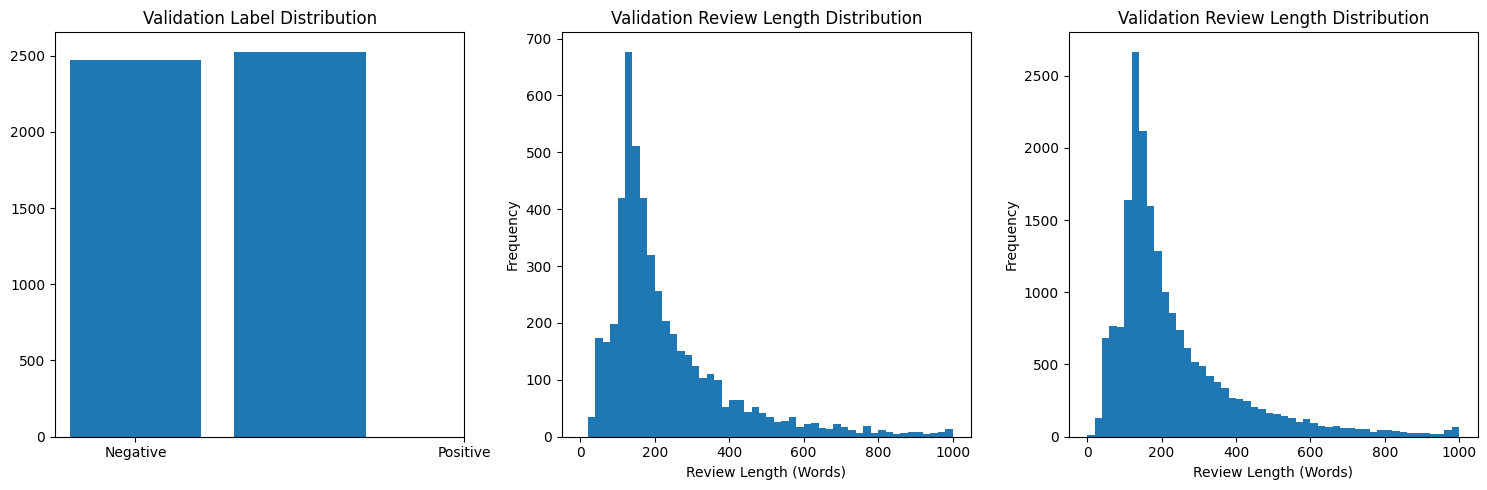

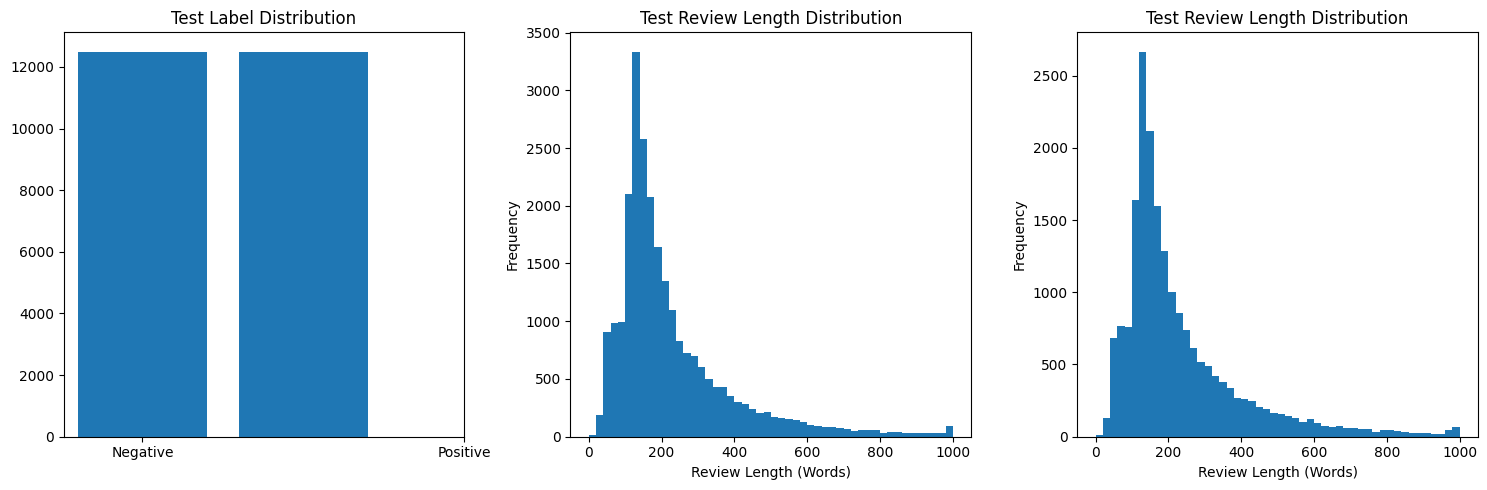


Average Training Review Length: 233.90 words
Average Validation Review Length: 233.35 words
Average Test Review Length: 228.53 words


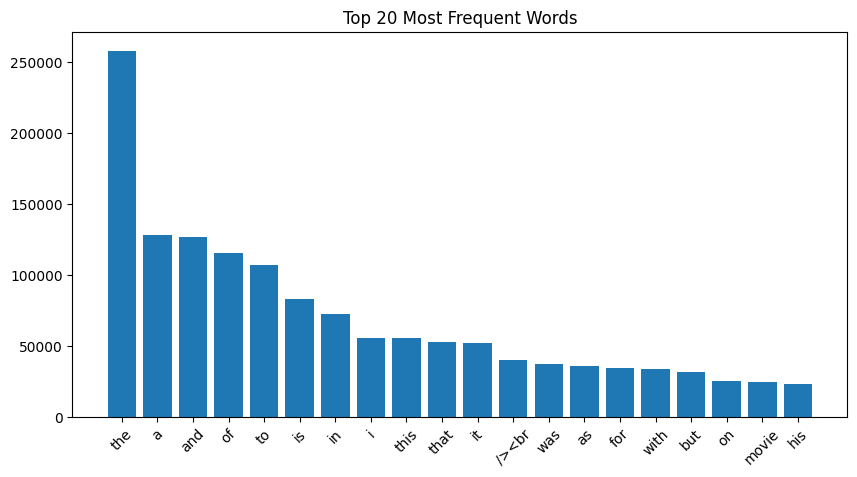

Average Word Length: 4.67
Unique Word Count: 219700
Review Length Standard Deviation: 173.50
Html tag count: 81191
Special character count: 1066364


In [15]:
# Plot label and review length distributions for a given dataset configuration
def plot_distributions(labels_list, lengths_list, title_prefix):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(labels_list[0], bins=2, rwidth=0.8, align='left')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title(f'{title_prefix} Label Distribution')

    plt.subplot(1, 3, 2)
    plt.hist(lengths_list[0], bins=50, range=(0, 1000))
    plt.title(f'{title_prefix} Review Length Distribution')
    plt.xlabel('Review Length (Words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(lengths_list[1], bins=50, range=(0, 1000))
    plt.title(f'{title_prefix} Review Length Distribution')
    plt.xlabel('Review Length (Words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


# Analyze word frequency and length from a list of texts
def analyze_words(text_list):
    all_words = []
    for text, _ in text_list:
        all_words.extend(text.decode('utf-8').lower().split())

    word_counts = collections.Counter(all_words)
    top_words = word_counts.most_common(20)

    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title('Top 20 Most Frequent Words')
    plt.show()

    word_lengths = [len(word) for word in all_words]
    print(f"Average Word Length: {np.mean(word_lengths):.2f}")
    print(f"Unique Word Count: {len(set(all_words))}")


# Analyze counts of HTML tags and special characters in text data
def analyze_special_chars(text_list):
    html_tag_regex = re.compile(r'<[^>]+>')
    special_char_regex = re.compile(r'[^a-zA-Z0-9\s]')

    html_tag_count = 0
    special_char_count = 0

    for text, _ in text_list:
        decoded_text = text.decode('utf-8')
        html_tag_count += len(html_tag_regex.findall(decoded_text))
        special_char_count += len(special_char_regex.findall(decoded_text))

    print(f"Html tag count: {html_tag_count}")
    print(f"Special character count: {special_char_count}")


# Calculate review lengths for each dataset
train_lengths = [len(text.decode('utf-8').split()) for text, _ in train_list]
validation_lengths = [len(text.decode('utf-8').split()) for text, _ in validation_list]
test_lengths = [len(text.decode('utf-8').split()) for text, _ in test_list]

# Plot distributions
plot_distributions([train_labels, validation_labels, test_labels],
                   [train_lengths, validation_lengths, test_lengths], 'Training')
plot_distributions([validation_labels, train_labels, test_labels],
                   [validation_lengths, train_lengths, test_lengths], 'Validation')
plot_distributions([test_labels, train_labels, validation_labels],
                   [test_lengths, train_lengths, validation_lengths], 'Test')

print(f"\nAverage Training Review Length: {np.mean(train_lengths):.2f} words")
print(f"Average Validation Review Length: {np.mean(validation_lengths):.2f} words")
print(f"Average Test Review Length: {np.mean(test_lengths):.2f} words")

analyze_words(train_list)

print(f"Review Length Standard Deviation: {np.std(train_lengths):.2f}")

analyze_special_chars(train_list)

Text Preprocessing

In [16]:
# Remove HTML tags from text using regex
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Decode byte strings and clean text by removing HTML tags
def decode_clean_text(data_list):
    sentences = [remove_html_tags(text.decode('utf-8')) for text, _ in data_list]
    return sentences

# Tokenize text and pad sequences for a consistent input shape
def tokenize_pad_sequences(train_sentences, validation_sentences, test_sentences, num_words=20000, max_length=200):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_sentences)

    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)

    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
    validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post', truncating='post')
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

    return train_padded, validation_padded, test_padded

# Convert padded sequences and labels to PyTorch tensors and create DataLoaders
def create_tensors_dataloaders(train_padded, validation_padded, test_padded, train_list, validation_list, test_list, batch_size=64):
    train_labels_np = np.array([label for _, label in train_list])
    validation_labels_np = np.array([label for _, label in validation_list])
    test_labels_np = np.array([label for _, label in test_list])

    train_data = torch.tensor(train_padded, dtype=torch.long)
    train_labels_tensor = torch.tensor(train_labels_np, dtype=torch.float32).view(-1, 1)
    validation_data = torch.tensor(validation_padded, dtype=torch.long)
    validation_labels_tensor = torch.tensor(validation_labels_np, dtype=torch.float32).view(-1, 1)
    test_data = torch.tensor(test_padded, dtype=torch.long)
    test_labels_tensor = torch.tensor(test_labels_np, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(train_data, train_labels_tensor)
    validation_dataset = TensorDataset(validation_data, validation_labels_tensor)
    test_dataset = TensorDataset(test_data, test_labels_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, validation_loader, test_loader

# Process text data through decoding, tokenizing, padding, and conversion to DataLoaders
def process_text(train_list, validation_list, test_list, num_words=20000, max_length=200, batch_size=64):
    train_sentences = decode_clean_text(train_list)
    validation_sentences = decode_clean_text(validation_list)
    test_sentences = decode_clean_text(test_list)

    train_padded, validation_padded, test_padded = tokenize_pad_sequences(
        train_sentences, validation_sentences, test_sentences, num_words, max_length
    )

    train_loader, validation_loader, test_loader = create_tensors_dataloaders(
        train_padded, validation_padded, test_padded, train_list, validation_list, test_list, batch_size
    )

    return train_loader, validation_loader, test_loader

train_loader, validation_loader, test_loader = process_text(train_list, validation_list, test_list)

Model definition

In [17]:
# Create and return an RNN model with normalization layers
def create_rnn_model(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, device):
    class RNN(nn.Module):
        def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate):
            super(RNN, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.embedding_norm = nn.LayerNorm(embedding_dim)
            self.gru = nn.GRU(
                embedding_dim,
                hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                batch_first=True,
                dropout=dropout_rate if num_layers > 1 else 0
            )
            self.gru_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
            self.fc_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)
            self.sigmoid = nn.Sigmoid()

        def forward(self, text):
            embedded = self.embedding(text)
            embedded_norm = self.embedding_norm(embedded)
            output, hidden = self.gru(embedded_norm)
            if self.gru.bidirectional:
                hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
            else:
                hidden = hidden[-1, :, :]
            hidden_norm = self.gru_norm(hidden)
            hidden_drop = self.dropout(hidden_norm)
            hidden_fc_norm = self.fc_norm(hidden_drop)
            out = self.fc(hidden_fc_norm)
            return self.sigmoid(out)
    return RNN(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate).to(device)

# Model Parameters
vocab_size = 20000
embedding_dim = 16
hidden_dim = 32
output_dim = 1
num_layers = 5
bidirectional = True
dropout_rate = 0.4
weight_decay = 0.0001

# Create the model
model = create_rnn_model(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, device)

Training The model

Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6923          0.5308          0.6877          0.5552         
2          0.6574          0.6103          0.6211          0.6652         
3          0.5265          0.7446          0.4973          0.7740         
4          0.4101          0.8190          0.4676          0.8038         
5          0.3450          0.8554          0.4939          0.8084         
6          0.3001          0.8791          0.3759          0.8414         
7          0.2634          0.8987          0.4656          0.8398         
8          0.2297          0.9181          0.4631          0.8482         
9          0.1998          0.9290          0.4608          0.8458         
10         0.1842          0.9381          0.5533          0.8308         


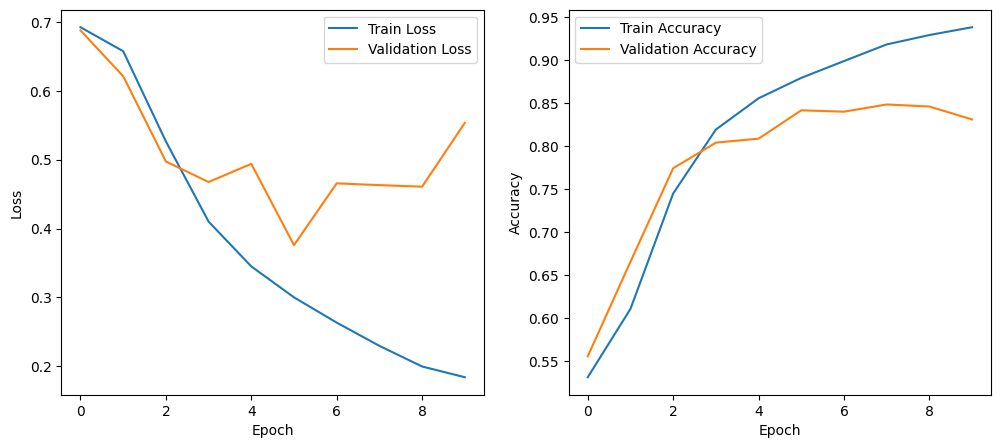

In [18]:
# Train and validate the model using early stopping
def train_validate(model, train_loader, validation_loader, epochs=10, patience=5):
    torch.cuda.empty_cache()

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    counter = 0

    print("{:<10} {:<15} {:<15} {:<15} {:<15}".format("Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc"))
    print("-" * 65)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_text, batch_labels in train_loader:
            batch_text = batch_text.to(model.embedding.weight.device)
            batch_labels = batch_labels.to(model.embedding.weight.device)
            optimizer.zero_grad()
            predictions = model(batch_text)
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predicted_train = torch.round(predictions)
            correct_train += (predicted_train == batch_labels).sum().item()
            total_train += batch_labels.size(0)

        train_accuracy = correct_train / total_train
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_text, batch_labels in validation_loader:
                batch_text = batch_text.to(model.embedding.weight.device)
                batch_labels = batch_labels.to(model.embedding.weight.device)
                predictions = model(batch_text)
                loss = criterion(predictions, batch_labels)
                total_val_loss += loss.item()
                predicted_val = torch.round(predictions)
                correct_val += (predicted_val == batch_labels).sum().item()
                total_val += batch_labels.size(0)

        val_accuracy = correct_val / total_val
        avg_val_loss = total_val_loss / len(validation_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print("{:<10} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".format(epoch + 1, avg_train_loss, train_accuracy, avg_val_loss, val_accuracy))

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


# Plot training and validation losses and accuracies
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Train and validate the model
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, validation_loader)
# Plot the results
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

Test execution

In [19]:
# Evaluate model performance on test data
criterion = nn.BCELoss()

model.eval()
test_loss = 0
correct_test = 0
with torch.no_grad():
    for batch_text, batch_labels in test_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_text)
        test_loss += criterion(predictions, batch_labels).item()
        predicted_test = torch.round(predictions)
        correct_test += (predicted_test == batch_labels).sum().item()

test_accuracy = correct_test / len(test_loader.dataset)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5794, Test Accuracy: 0.8196


GridSearchCV

In [20]:
# Convert (text, label) pairs to texts and labels as NumPy arrays
def convert_to_numpy(data_list):
    texts = [text.decode('utf-8') for text, _ in data_list]
    labels = np.array([label for _, label in data_list])
    return texts, labels

train_texts, train_labels = convert_to_numpy(train_list)
test_texts, test_labels = convert_to_numpy(test_list)

# Tokenize text data and pad sequences to a fixed length
def tokenize_pad(texts, max_length=200, num_words=20000):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded_sequences

train_data = tokenize_pad(train_texts)
test_data = tokenize_pad(test_texts)

# Device assignment for torch computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom GRU classifier wrapped as a scikit-learn estimator
class PyTorchGRUClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, weight_decay, epochs=10, patience=3):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.patience = patience
        self.model = None

    def fit(self, X, y):
        print("Model Parameters:")
        print(f"  Vocab Size: {self.vocab_size}")
        print(f"  Embedding Dim: {self.embedding_dim}")
        print(f"  Hidden Dim: {self.hidden_dim}")
        print(f"  Output Dim: {self.output_dim}")
        print(f"  Num Layers: {self.num_layers}")
        print(f"  Bidirectional: {self.bidirectional}")
        print(f"  Dropout Rate: {self.dropout_rate}")
        print(f"  Weight Decay: {self.weight_decay}")
        print(f"  Epochs: {self.epochs}")
        print("="*50)
        train_dataset = TensorDataset(torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.float32).view(-1, 1))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        val_size = int(0.2 * len(train_dataset))
        train_size = len(train_dataset) - val_size
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        validation_loader = DataLoader(val_subset, batch_size=32)

        class RNN(nn.Module):
            def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate):
                super(RNN, self).__init__()
                self.embedding = nn.Embedding(vocab_size, embedding_dim)
                self.embedding_norm = nn.LayerNorm(embedding_dim)
                self.gru = nn.GRU(
                    embedding_dim,
                    hidden_dim,
                    num_layers=num_layers,
                    bidirectional=bidirectional,
                    batch_first=True,
                    dropout=dropout_rate if num_layers > 1 else 0
                )
                self.gru_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)
                self.dropout = nn.Dropout(dropout_rate)
                self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
                self.fc_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)
                self.sigmoid = nn.Sigmoid()

            def forward(self, text):
                embedded = self.embedding(text)
                embedded_norm = self.embedding_norm(embedded)
                output, hidden = self.gru(embedded_norm)
                if bidirectional:
                    hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
                else:
                    hidden = hidden[-1, :, :]
                hidden_norm = self.gru_norm(hidden)
                hidden_drop = self.dropout(hidden_norm)
                hidden_fc_norm = self.fc_norm(hidden_drop)
                out = self.fc(hidden_fc_norm)
                return self.sigmoid(out)

        self.model = RNN(self.vocab_size, self.embedding_dim, self.hidden_dim, self.output_dim,
                         self.num_layers, self.bidirectional, self.dropout_rate).to(device)
        train_validate(self.model, train_loader, validation_loader, self.epochs, self.patience)
        return self

    def predict(self, X):
        test_dataset = TensorDataset(torch.tensor(X, dtype=torch.long))
        test_loader = DataLoader(test_dataset, batch_size=32)

        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch_text, in test_loader:
                batch_text = batch_text.to(device)
                preds = self.model(batch_text)
                predictions.extend(torch.round(preds).cpu().numpy())
        return np.array(predictions).flatten()

pipeline = Pipeline([
    ('gru', PyTorchGRUClassifier(vocab_size=20000, output_dim=1, embedding_dim=8, hidden_dim=16,
                                 num_layers=3, bidirectional=True, dropout_rate=0.5, weight_decay=1e-5,
                                 epochs=10, patience=3))
])

param_grid = {
    'gru__embedding_dim': [16, 32, 64],
    'gru__hidden_dim': [16, 32, 64],
    'gru__num_layers': [2, 3],
    'gru__bidirectional': [True, False],
    'gru__dropout_rate': [0.4, 0.5],
    'gru__weight_decay': [1e-3, 1e-4],
    'gru__epochs': [10],
    'gru__patience': [3]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=1)
grid_search.fit(train_data, train_labels)

if grid_search.best_estimator_:
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # Evaluate on test data
    predictions = grid_search.predict(test_data)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Test Accuracy: {accuracy}")
else:
    print("GridSearchCV did not complete successfully.")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7031          0.5034          0.6885          0.5326         
2          0.6825          0.5523          0.6429          0.6317         
3          0.6369          0.6473          0.5751          0.7123         
4          0.5177          0.7527          0.4175          0.8162         
5          0.4249          0.8214          0.3386          0.8691         
6          0.3536          0.8588          0.3013          0.8916         
7          0.3016          0.8851          0.2340          0.9216         
8          0.2605          0.9086          0.2125          0.9359         
9          0

KeyboardInterrupt: 

In [ ]:
# Set best parameters and evaluate model on test data
best_model = grid_search.best_estimator_.named_steps["gru"].model
criterion = nn.BCELoss()

best_model.eval()
test_loss = 0
correct_test = 0
with torch.no_grad():
    for batch_text, batch_labels in test_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        predictions = best_model(batch_text)
        test_loss += criterion(predictions, batch_labels).item()
        predicted_test = torch.round(predictions)
        correct_test += (predicted_test == batch_labels).sum().item()

test_accuracy = correct_test / len(test_loader.dataset)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 2.4494, Test Accuracy: 0.5397
